In [1]:
import sys
import os
import time
import logging
import datetime
from datetime import datetime, timedelta
import yaml
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import requests
import pandas_gbq
from dreams_core.googlecloud import GoogleCloud as dgc
from dreams_core import core as dc
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema


# import local files if necessary
sys.path.append('..//src')
import training_data as td
importlib.reload(td)

# load dotenv
load_dotenv()

# configure logger
logger = dc.setup_logger()
logger.setLevel(logging.DEBUG)

# Custom format function for displaying numbers
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')


def load_config(file_path='config.yaml'):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
config = load_config()


#### Load the datasets

In [3]:
importlib.reload(td)
config = load_config()


# retrieve prices data
if 'prices_filled_df' not in locals():
    prices_df = td.retrieve_prices_data()

    # fill gaps in prices data
    prices_df,prices_outcomes_df = td.fill_prices_gaps(prices_df,config['data_cleaning']['max_gap_days'])
logger.info(f"Prices data shape: {prices_df.shape}")


# Retrieve or load transfers data
if 'transfers_df' not in locals():
    transfers_df = td.retrieve_transfers_data(
        config['modeling']['training_period_start'],
        config['modeling']['modeling_period_start'],
        config['modeling']['modeling_period_end']
        )
logger.info(f"Transfers data shape: {transfers_df.shape}")


# # Calculate and clean profits data
# profits_df = td.calculate_wallet_profitability(transfers_df, prices_df)
# profits_df, exclusions_profits_df = td.clean_profits_df(profits_df, config['data_cleaning']['profitability_filter'])
# logger.info(f"Profits data shape: {profits_df.shape}")

# profits_df.head()

[08/Sep/2024 22:30:28] INFO [dreams_core.core.retrieve_prices_data:34] retrieving prices data...
[08/Sep/2024 22:30:31] INFO [dreams_core.core.fill_prices_gaps:123] retained 401 coins.
[08/Sep/2024 22:30:31] INFO [dreams_core.core.fill_prices_gaps:124] 382 coins had no gaps, 19 coins had gaps filled, and 38 coins were dropped due to large gaps.
[08/Sep/2024 22:30:31] INFO [dreams_core.core.<module>:11] Prices data shape: (110929, 3)
[08/Sep/2024 22:30:31] INFO [dreams_core.core.retrieve_transfers_data:330] retrieving transfers data...
[08/Sep/2024 22:30:50] INFO [dreams_core.core.retrieve_transfers_data:337] retrieved transfers_df with shape (12885534, 5) after 18.7 seconds.
[08/Sep/2024 22:30:50] INFO [dreams_core.core.<module>:21] Transfers data shape: (12885534, 5)


TypeError: calculate_wallet_profitability() takes 1 positional argument but 2 were given

### Work with the datasets

In [4]:
importlib.reload(td)
config = load_config()

profits_df = td.prepare_profits_data(transfers_df, prices_df)
# profits_df = td.calculate_wallet_profitability(profits_df)
profits_df.head()

[08/Sep/2024 22:30:55] INFO [dreams_core.core.prepare_profits_data:378] Preparing profits_df data...
[08/Sep/2024 22:30:57] DEBUG [dreams_core.core.prepare_profits_data:395] <Step 1> merge transfers and prices: 2.25 seconds
[08/Sep/2024 22:30:59] DEBUG [dreams_core.core.prepare_profits_data:410] <Step 2> identify first prices of coins: 2.39 seconds
[08/Sep/2024 22:31:01] DEBUG [dreams_core.core.prepare_profits_data:433] <Step 3> created new records as of the first_price_date: 1.35 seconds
[08/Sep/2024 22:31:06] DEBUG [dreams_core.core.prepare_profits_data:449] <Step 4> merge new records into profits_df: 5.93 seconds


,coin_id,wallet_address,date,net_transfers,balance,price
0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-23,5.2e-08,5.2e-08,1.88983550773
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-28,0.002920722,0.002920774,7.47303212902
2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-31,0,0.002920774,27.5991647724
3,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-13,2.38776413,2.38776413,2.20442838263
4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-31,0,2.38776413,27.5991647724


In [5]:
def sample_transfers_df():
    """
    Create a sample transfers DataFrame for testing.
    """
    data = {
        'coin_id': ['BTC', 'BTC', 'ETH', 'ETH', 'BTC', 'ETH', 'MYRO', 'MYRO', 'MYRO', 
                    'BTC', 'ETH', 'BTC', 'ETH', 'MYRO'],
        'wallet_address': ['wallet1', 'wallet1', 'wallet1', 'wallet2', 'wallet2', 'wallet2', 'wallet3', 'wallet3', 'wallet3',
                           'wallet1', 'wallet1', 'wallet2', 'wallet2', 'wallet3'],
        'date': [
            '2023-01-01', '2023-02-01', '2023-01-01', '2023-01-01', '2023-01-01', '2023-02-01', 
            '2023-01-01', '2023-02-01', '2023-03-01',
            '2023-04-01', '2023-04-01', '2023-04-01', '2023-04-01', '2023-04-01'
        ],
        'net_transfers': [10.0, 5, 100, 50, 20, 25, 1000, 500, -750,
                          0, 0, 0, -10, 0],
        'balance': [10.0, 15, 100, 50, 20, 75, 1000, 1500, 750,
                    15, 100, 20, 65, 750]
    }
    df = pd.DataFrame(data)

    # Convert coin_id to categorical and date to datetime
    df['coin_id'] = df['coin_id'].astype('category')
    df['date'] = pd.to_datetime(df['date'])

    return df

def sample_prices_df():
    """
    Create a sample prices DataFrame for testing.
    """
    data = {
        'coin_id': ['BTC', 'BTC', 'BTC', 'BTC', 'ETH', 'ETH', 'ETH', 'ETH', 'MYRO', 'MYRO', 'MYRO', 'MYRO'],
        'date': [
            '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
            '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
            '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01'
        ],
        'price': [20000, 21000, 22000, 23000, 1500, 1600, 1700, 1800, 10, 15, 12, 8]
    }
    df = pd.DataFrame(data)

    # Convert coin_id to categorical and date to datetime
    df['coin_id'] = df['coin_id'].astype('category')
    df['date'] = pd.to_datetime(df['date'])

    return df

sample_transfers_df = sample_transfers_df()
sample_prices_df = sample_prices_df()

In [6]:
transfers_df.dtypes

coin_id                 category
wallet_address            object
date              datetime64[ns]
net_transfers            float64
balance                  float64
dtype: object

In [7]:
sample_transfers_df.dtypes

coin_id                 category
wallet_address            object
date              datetime64[ns]
net_transfers              int64
balance                    int64
dtype: object

In [93]:
importlib.reload(td)
config = load_config()

profits_df = td.calculate_wallet_profitability(profits_df)
profits_df.head()

[08/Sep/2024 22:00:59] INFO [dreams_core.core.calculate_wallet_profitability:489] Starting generation of profits_df...
[08/Sep/2024 22:01:06] DEBUG [dreams_core.core.calculate_wallet_profitability:501] Offset prices and balances for profitability logic: 6.65 seconds
[08/Sep/2024 22:01:09] DEBUG [dreams_core.core.calculate_wallet_profitability:508] Calculate profitability: 3.38 seconds
[08/Sep/2024 22:01:13] DEBUG [dreams_core.core.calculate_wallet_profitability:518] Calculate rate of return 4.22 seconds
[08/Sep/2024 22:01:14] INFO [dreams_core.core.calculate_wallet_profitability:525] Generated profits df after 14.95 seconds


,coin_id,wallet_address,date,net_transfers,balance,price,first_price,profits_change,profits_total,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-23,5.2e-08,5.2e-08,1.88983550773,2.20442838263,0,0,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,9.82714464018e-08,0
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-28,0.002920722,0.002920774,7.47303212902,2.20442838263,2.90326224307e-07,2.90326224307e-07,0.0218270379436,0.0218266493459,0.0218266493459,0.0218267476174,1.33013964974e-05
2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-31,0,0.002920774,27.5991647724,2.20442838263,0.0587838849452,0.0587841752714,0.0806109228888,0,0,0.0218267476174,2.69321734515
3,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-13,2.38776413,2.38776413,2.20442838263,2.20442838263,0,0,5.26365501921,5.26365501921,5.26365501921,5.26365501921,0
4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-31,0,2.38776413,27.5991647724,2.20442838263,60.6366406422,60.6366406422,65.9002956614,0,0,5.26365501921,11.5198736279


In [92]:
profits_df.describe()

,net_transfers,balance,price,first_price,profits_change,profits_total,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
count,11361981,11361981,11361981,11361981,11361981,11361981,11361981,11361981,11361981,11361981,10336492
mean,124750574.276,2386056626.61,2.37903079662,0.894608276176,8558.19204412,86796.4885836,153865.345004,2732.9276972,5318.79582257,126308.7095,15716612.2641
std,62829386975.5,190792278786,11.3975966207,15.5859600903,6800050.84922,14237267.9757,20198805.3197,3006381.02874,2989709.2251,8676918.40347,34751279613
min,-2.70361394926e+13,-0.00900719925474,4.84801006305e-09,4.84801006305e-09,-429806030.697,-949528253.509,-2.05024608804e-07,-521376980.892,0,0,-45775366262.7
25%,0,0,0.00599633743862,0.00137518652402,0,0,0,0,0,20.2289300435,0
50%,0,190.114068441,0.0805568865062,0.0134619148653,0,0,47.278292917,0,0,246.091278865,0.0155984687292
75%,282.217323915,13296.8213259,0.999721913528,0.185161415287,11.5061001343,166.294010319,766.844304004,58.7823260718,58.7823260718,1532.65070125,0.591444078651
max,1.40483972029e+14,1.40483972029e+14,452.940948917,607.711623069,18135066982.1,21118654214.2,28770556951.1,7651902736.91,7651902736.91,7651902736.91,1.0395260629e+14


In [9]:
audit_df = transfers_df[(transfers_df['coin_id']==c) & (transfers_df['wallet_address']==w)]
profits_df_test = td.calculate_wallet_profitability(audit_df,prices_df)
profits_df_test

[08/Sep/2024 20:53:52] INFO [dreams_core.core.calculate_wallet_profitability:378] Starting generation of profits_df...
/Users/jeremymeadow/DreamsData/GitHub/data-science/notebooks/..//src/training_data.py:388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers_df['date'] = pd.to_datetime(transfers_df['date'])
/Users/jeremymeadow/DreamsData/GitHub/data-science/notebooks/..//src/training_data.py:390: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers_df['coin_id'] = transfers_df['coin_id'].astype('c

,coin_id,wallet_address,date,net_transfers,balance,price,profits_change,profits_total,usd_balance,usd_net_transfers,usd_inflows,usd_total_inflows,total_return
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000a991c429ee2ec6df19d40fe0c80088b8,2024-03-31,0,216.04104,27.5991647724,0,0,5962.55226055,0,0,0,NaN


In [23]:
# merge datasets
profits_df = pd.merge(transfers_df_full, prices_df, on=['coin_id', 'date'], how='left')
logger.debug(f"<Step 1> (Merge transfers and prices): {time.time() - start_time:.2f} seconds")
step_time = time.time()

# 2. Remove transfers earlier than each coin's first pricing data
# ---------------------------------------------------------------
# identify the earliest pricing data for each coin
first_prices_df = prices_df.groupby('coin_id')['date'].min().reset_index()
first_prices_df.columns = ['coin_id', 'first_price_date']

# remove transfer data that occurred when we don't know the coin price
profits_df = pd.merge(profits_df, first_prices_df, on='coin_id', how='left')

profits_df.head()

[08/Sep/2024 21:10:49] DEBUG [dreams_core.core.<module>:3] <Step 1> (Merge transfers and prices): 697.41 seconds


,coin_id,wallet_address,date,net_transfers,balance,price,first_price_date
0,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-23,5.2e-08,5.2e-08,1.88983550773,2024-03-13
1,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-28,0.002920722,0.002920774,7.47303212902,2024-03-13
2,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-03-31,0,0.002920774,27.5991647724,2024-03-13
3,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-12,2.38776413,2.38776413,NaN,2024-03-13
4,04f6120a-f0dd-4260-bb2b-b8f827fdba61,0x000000004685666c7653cc148f566f0511901b37,2024-03-31,0,2.38776413,27.5991647724,2024-03-13


In [28]:
# Filter rows where the price is NaN
nan_price_df = profits_df[profits_df['price'].isna()]

# Group by coin_id and wallet_address, and filter groups with more than one record
multiple_nan_price_pairs = nan_price_df.groupby(['coin_id', 'wallet_address']).filter(lambda x: len(x) > 1)

# Display the result
multiple_nan_price_pairs


,coin_id,wallet_address,date,net_transfers,balance,price,first_price_date
8608,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x00000000003b3cc22af3ae1eac0440bcee416b40,2023-02-02,0.00081674,0.00730953,NaN,2023-05-25
8609,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x00000000003b3cc22af3ae1eac0440bcee416b40,2023-03-19,0.00507654,0.01238607,NaN,2023-05-25
8638,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x00000000500e2fece27a7600435d0c48d64e0c00,2023-01-20,0.00065536,0.00851968,NaN,2023-05-25
8639,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x00000000500e2fece27a7600435d0c48d64e0c00,2023-01-23,0.00065536,0.00917504,NaN,2023-05-25
8642,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x00000000a991c429ee2ec6df19d40fe0c80088b8,2023-01-24,3e-08,3.1e-07,NaN,2023-05-25
...,...,...,...,...,...,...,...
12873165,f9d19e1d-8637-4e7c-b808-4b4bfe18e316,0xffe8a331bc3d8e600f7abdae1cbbbd8ab9d982ff,2024-03-29,30.4399777972,101.909083031,NaN,2024-03-31
12873169,f9d19e1d-8637-4e7c-b808-4b4bfe18e316,0xffee706cb7e57859a4c6f2e2e1f8950f03400a39,2024-03-25,0.015172971279,0.015172971279,NaN,2024-03-31
12873170,f9d19e1d-8637-4e7c-b808-4b4bfe18e316,0xffee706cb7e57859a4c6f2e2e1f8950f03400a39,2024-03-30,1.82527369828,1.84044666956,NaN,2024-03-31
12873174,f9d19e1d-8637-4e7c-b808-4b4bfe18e316,0xfff9a552721764e8b8e3513a95a1cdcd304d8012,2023-12-29,0.34800487835,0.34800487835,NaN,2024-03-31


In [30]:
multiple_nan_price_pairs.sample(10)

,coin_id,wallet_address,date,net_transfers,balance,price,first_price_date
9568480,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x6aba6a02ca1e019f15bd2a7e0f5200f0fbeb0bef,2023-06-19,-16292775809.3,5.96046447754e-07,NaN,2023-09-04
9799151,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x8a6f7c5f6a657ba33506f50467347cbbbe4d8de5,2023-06-07,-1541898286.54,0,NaN,2023-09-04
215248,0eedc336-a78e-4b25-957e-57117227ef78,0x0e10677e4f1d52e4290578c8d49721e0cb7e4721,2023-04-23,15416.7661,40481.9176,NaN,2023-05-25
8927136,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x12b7f83767e3ea7d7d43a10b89d248a7ebfbf794,2023-05-11,-1173205406.93,0,NaN,2023-09-04
10439316,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0xe32058676c3a5f192e07fb14955508b9cc4349a3,2023-04-30,161967035.808,231002098.688,NaN,2023-09-04
9815110,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x8cb8b6c24ee13bcdb644cd1b3e89a87d6923b909,2023-04-24,-413909662.856,2100000000,NaN,2023-09-04
9679424,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-06-13,-25000000000,250000000000,NaN,2023-09-04
6125828,63c83c7e-e33b-43ce-b2f0-01c77b246a48,0xf60f0a5cbb2d1299abefef0d32fa90ee5a825b4b,2023-02-06,6886.13881029,6886.13881029,NaN,2023-05-25
2358072,28ca1667-51aa-44ed-822d-7f5a28738a16,0x6d4beb94f60ec025e64a375a7df00980afc34bde,2023-03-29,-21059.6544639,5.45696821064e-12,NaN,2023-05-25
154772,0e1c102e-2e7d-4aed-af2d-1526c2e0720a,0x9b533098929311730d104a787b91dd2a0e5d8b2a,2023-01-13,18460.406407,18460.406407,NaN,2023-05-25


In [79]:
c = 'b6186979-8b3a-49ed-a51c-49f75bbe65f0'
w = '0x8cb8b6c24ee13bcdb644cd1b3e89a87d6923b909'
# 0x8cb8b6c24ee13bcdb644cd1b3e89a87d6923b909
# 0x79d5f8c3e81d687772ffb681711332aa736a45e7
# transfers_df_full = transfers_df
transfers_df = transfers_df_full[
    (transfers_df_full['wallet_address'].isin(['0xe32058676c3a5f192e07fb14955508b9cc4349a3', '0x79d5f8c3e81d687772ffb681711332aa736a45e7'])) &
    (transfers_df_full['coin_id'] == c)
].copy()

transfers_df


,coin_id,wallet_address,date,net_transfers,balance
9679422,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-05-05,500000000000,500000000000
9679423,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-06-12,-225000000000,275000000000
9679424,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-06-13,-25000000000,250000000000
9679425,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-06-14,-50000000000,200000000000
9679426,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-07-24,-4166096334.2,195833903666
9679427,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-07-26,4170000000,200003903666
9679428,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-07-27,-66051249140.7,133952654525
9679429,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-07-28,-133952654525,3.33786010742e-06
9679430,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-11-09,15000000000,15000000000
9679431,b6186979-8b3a-49ed-a51c-49f75bbe65f0,0x79d5f8c3e81d687772ffb681711332aa736a45e7,2023-11-10,-15000000000,3.33786010742e-06


In [82]:
transfers_df = transfers_df_full

In [84]:
logger.info("Preparing profits_df data...")
start_time = time.time()

# Raise an error if either df is empty
if transfers_df.empty or prices_df.empty:
    raise ValueError("Input DataFrames cannot be empty.")

# 1. Merge transfers and prices data on 'coin_id' and 'date'
# ----------------------------------------------------------
# set dates to datetime and coin_ids to categorical
transfers_df['date'] = pd.to_datetime(transfers_df['date'])
prices_df['date'] = pd.to_datetime(prices_df['date'])
transfers_df['coin_id'] = transfers_df['coin_id'].astype('category')
prices_df['coin_id'] = prices_df['coin_id'].astype('category')

# merge datasets
profits_df = pd.merge(transfers_df, prices_df, on=['coin_id', 'date'], how='left')
logger.debug(f"<Step 1> Merge transfers and prices: {time.time() - start_time:.2f} seconds")
step_time = time.time()


# 2. Create a filler transfer record for wallets that had balances prior to pricing data
# --------------------------------------------------------------------------------------
# Identify the earliest pricing data for each coin and merge to get the first price date
first_prices_df = prices_df.groupby('coin_id').agg({
    'date': 'min',
    'price': 'first'  # Assuming we want the first available price on the first_price_date
}).reset_index()
first_prices_df.columns = ['coin_id', 'first_price_date', 'first_price']

# Merge the first price data into profits_df
profits_df = profits_df.merge(first_prices_df, on='coin_id', how='left')

# Identify wallets with transfer data before first_price_date
pre_price_transfers = profits_df[profits_df['date'] < profits_df['first_price_date']]

# Group by coin_id and wallet_address to ensure only one record per pair
grouped_pre_price_transfers = pre_price_transfers.groupby(['coin_id', 'wallet_address']).agg({
    'first_price_date': 'first',
    'balance': 'last',  # Get the balance as of the latest transfer before first_price_date
    'first_price': 'first'  # Retrieve the first price for this coin
}).reset_index()
logger.debug(f"<Step 2> identify first prices of coins: {time.time() - step_time:.2f} seconds")
step_time = time.time()

# Create the new records to reflect transfer in of balance as of first_price_date
new_records = grouped_pre_price_transfers.copy()
new_records['date'] = new_records['first_price_date']
new_records['net_transfers'] = new_records['balance']  # Treat the balance as a net transfer
new_records['price'] = new_records['first_price']  # Use the first price on the first_price_date

# # Select necessary columns for new records
new_records = new_records[['coin_id', 'wallet_address', 'date', 'net_transfers', 'balance', 'price', 'first_price_date', 'first_price']]

# Remove original records with no price data (NaN in 'price' column)
profits_df = profits_df[profits_df['price'].notna()]

# Append new records to the original dataframe
profits_df = pd.concat([profits_df, new_records], ignore_index=True)

# Sort by coin_id, wallet_address, and date to maintain order
profits_df = profits_df.sort_values(by=['coin_id', 'wallet_address', 'date']).reset_index(drop=True)
logger.debug(f"<Step 2> merge new values into profits_df: {time.time() - step_time:.2f} seconds")

return profits_df

[08/Sep/2024 21:48:30] DEBUG [dreams_core.core.<module>:12] <Step 1> Merge transfers and prices: 2.30 seconds
[08/Sep/2024 21:48:33] DEBUG [dreams_core.core.<module>:37] <Step 2> identify first prices of coins: 3.76 seconds
[08/Sep/2024 21:48:40] DEBUG [dreams_core.core.<module>:57] <Step 2> merge new values into profits_df: 6.75 seconds


(11361981, 8)

AttributeError: module 'training_data' has no attribute 'prepare_profits_data'

In [25]:
# shark_column = 'is_shark'
shark_type = 'is_returns_shark'



# # Calculate the number of coin_ids each wallet is a shark on
# shark_coins_df = sharks_df[sharks_df[shark_type]].groupby('wallet_address')['coin_id'].nunique().reset_index()
# shark_coins_df.columns = ['wallet_address', 'shark_coins']

# # Merge the two DataFrames
# wallet_analysis_df = wallet_analysis_df.merge(shark_coins_df, on='wallet_address', how='left')
# wallet_analysis_df['shark_coins'] = wallet_analysis_df['shark_coins'].fillna(0)

# # Calculate the shark_rate for each wallet
# wallet_analysis_df['shark_rate'] = wallet_analysis_df['shark_coins'] / wallet_analysis_df['total_coins']

# # wallet_analysis_df.groupby('total_coins').size()
# wallet_analysis_df.sort_values(by='total_coins',ascending=False)

wallet_analysis_df

# # Calculate the number of unique coin_ids each wallet has records with
# wallet_analysis_df = sharks_df.groupby('wallet_address')['coin_id'].nunique().reset_index()
# wallet_analysis_df.columns = ['wallet_address', 'total_coins']


,wallet_address,total_coins
0,0x000000000000c35e4364deffa9059dbadaefd4f8,3
1,0x00000000000a78c8727b6ae386f004e7e37a4875,1
2,0x000000000077cdff30a1b5d7c12f3587f921e519,1
3,0x0000000000a6f0986c92cf1ec4d2e77afbe1466d,1
4,0x0000000000b35ae47b12b8ccf2f8d51e208760c8,1
...,...,...
93837,zhVtHwNE8QGtTzN6tX7Ed24wDLKUuBCj7U5gMqxFD82,1
93838,zsZrkzcUBNzDZFHasSmBQ4gb9jYwFa3rLqRuTFsZ5Qm,1
93839,zuqaoapDTJhShSV4Us9AwTh6ibPWksTLAuTgmfZ2oTA,1
93840,zxVSE7ToQZbA3c7tha48T7cPbVDtui9NCXZNKXFqtjr,1


In [ ]:




# Step 2: Count how many coins each wallet is a shark in
shark_counts_df = shark_df.groupby('wallet_address')['coin_id'].nunique().reset_index()
shark_counts_df.columns = ['wallet_address', 'coin_count']

# Step 3: Filter wallets that are sharks in at least 'n_coins'
multi_coin_sharks_df = shark_counts_df[shark_counts_df['coin_count'] >= n_coins]

# Step 4: Filter for modeling period data
modeling_profits_df = profits_df[profits_df['date'] == modeling_period_end]

# Step 5: Separate multi-coin sharks from the rest of the population
multi_coin_sharks_profits = modeling_profits_df[
    modeling_profits_df['wallet_address'].isin(multi_coin_sharks_df['wallet_address'])
]

non_sharks_profits = modeling_profits_df[
    ~modeling_profits_df['wallet_address'].isin(multi_coin_sharks_df['wallet_address'])
]

# Step 6: Calculate the average profitability for sharks and non-sharks
sharks_avg_profit = multi_coin_sharks_profits['profitability'].mean()
non_sharks_avg_profit = non_sharks_profits['profitability'].mean()

# Step 7: Prepare the comparison DataFrame
sharks_performance_df = pd.DataFrame({
    'group': ['multi-coin sharks', 'non-sharks'],
    'avg_profitability': [sharks_avg_profit, non_sharks_avg_profit]
})

return sharks_performance_df


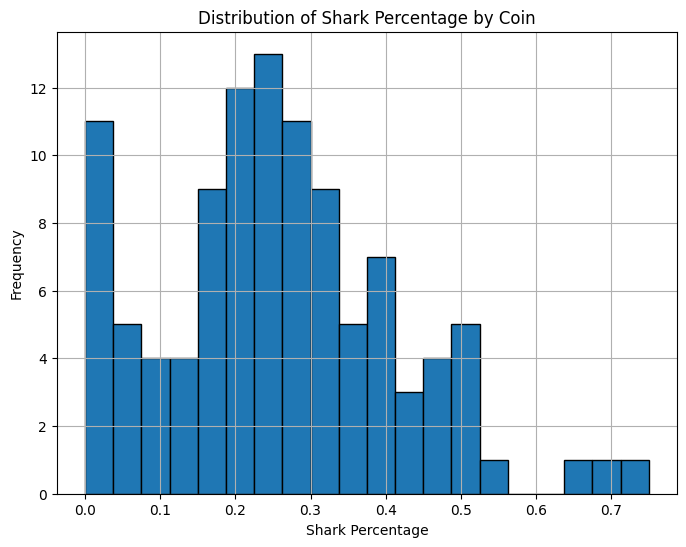

In [9]:
# shark_column = 'is_shark'
shark_column = 'is_returns_shark'

sharks = sharks_df.groupby('coin_id')[shark_column].sum()
wallets = sharks_df.groupby('coin_id').size()
shark_percentage_df = pd.DataFrame({
    'total_wallets': wallets,
    'shark_wallets': sharks
})
shark_percentage_df['shark_percentage'] = (shark_percentage_df['shark_wallets'] / shark_percentage_df['total_wallets'])

shark_percentage_df
import matplotlib.pyplot as plt

# Assuming 'shark_percentage_df' is available from the previous code

# Plot histogram of shark_percentage
plt.figure(figsize=(8, 6))
plt.hist(shark_percentage_df['shark_percentage'], bins=20, edgecolor='black')
plt.title('Distribution of Shark Percentage by Coin')
plt.xlabel('Shark Percentage')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


,wallet_address,total_coins,shark_coins,shark_rate
23666,0x75e89d5979e4f6fba9f97c104c2f0afb3f1dcb88,41,10,0.243902439024
2645,0x0d0707963952f2fba59dd06f2b425ace40b492fe,38,4,0.105263157895
17784,0x58edf78281334335effa23101bbe3371b6a36a51,29,0,0
5910,0x1d283807630ffb876a5d78b8e0788e491449f241,29,1,0.0344827586207
13706,0x446b86a33e2a438f569b15855189e3da28d027ba,27,17,0.62962962963
...,...,...,...,...
20476,0x65e9f4e84176eed10724165efc44ed5eebb66bf9,1,0,0
20477,0x65eac9b10fac99c2c0cb767493a852fce9abb08b,1,1,1
20478,0x65ebca66f0240e7e436637076d65e150dc850a36,1,0,0
20479,0x65ec05685f04743fd31454f443cfbc7164b393b8,1,0,0


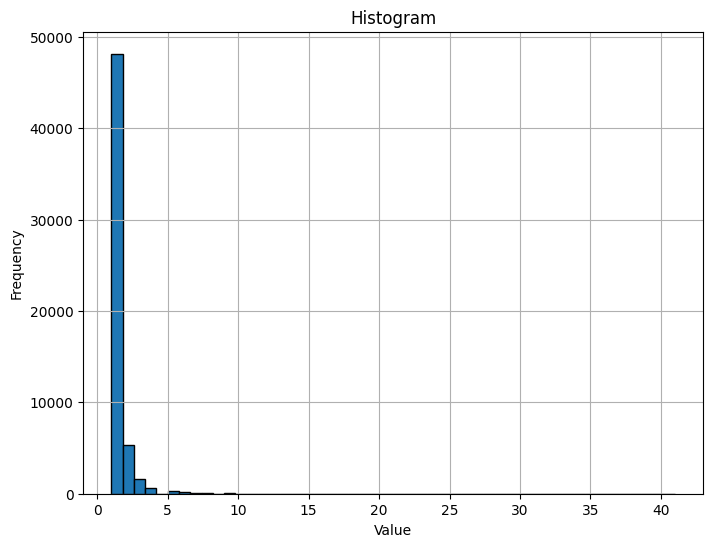

In [14]:
def plot_histogram(df, column, bins=10, title='Histogram', xlabel='Value', ylabel='Frequency'):
    """
    Plots a histogram for a specified column in a DataFrame.
    
    Parameters:
        df (DataFrame): The DataFrame containing the data.
        column (str): The column name to be used as the data for the histogram.
        bins (int, optional): The number of bins for the histogram. Default is 10.
        title (str, optional): The title of the histogram. Default is 'Histogram'.
        xlabel (str, optional): The label for the x-axis. Default is 'Value'.
        ylabel (str, optional): The label for the y-axis. Default is 'Frequency'.
    
    Returns:
        None: Displays the histogram plot.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Example usage with the wallet_analysis_df and shark_rate column
plot_histogram(wallet_analysis_df, 'total_coins', bins=50)


AttributeError: Rectangle.set() got an unexpected keyword argument 'xlim'

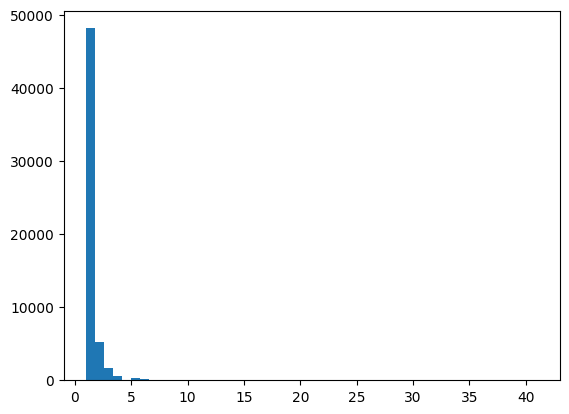

In [18]:
plt.hist(wallet_analysis_df['total_coins'],bins=50,xlim=25)

In [46]:
a = 'wallet2'
c = 'ETH'
result[(result['wallet_address'] == a) & (result['coin_id'] == c)]

,coin_id,wallet_address,date,net_transfers,balance,price,profitability_change,profitability_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_cumulative_inflows,total_return
3,ETH,wallet2,2023-01-01,50,50,1500,0,0,75000,75000,75000,75000,0
5,ETH,wallet2,2023-02-01,25,75,1600,5000,5000,120000,40000,40000,115000,0.0434782608696
12,ETH,wallet2,2023-04-01,-10,65,1800,15000,20000,117000,-18000,0,115000,0.173913043478


In [33]:
result[(result['wallet_address'] == 'wallet3') & (result['coin_id'] == 'MYRO')]

,coin_id,wallet_address,date,net_transfers,balance,price,profitability_change,profitability_cumulative,usd_balance,usd_net_transfers,usd_inflows,usd_cumulative_inflows,total_return
6,MYRO,wallet3,2023-01-01,1000,1000,10,0,0,10000,10000,10000,10000,0
7,MYRO,wallet3,2023-02-01,500,1500,15,5000,5000,22500,7500,7500,17500,0.285714285714
8,MYRO,wallet3,2023-03-01,-750,750,12,-4500,500,9000,-9000,0,17500,0.0285714285714


In [9]:
coin_id = '0b9d343d-4e25-4d22-b49c-fa17509a0333'
wallet_address = '0x000000000005af2ddc1a93a03e9b7014064d3b8d'
profits_df[(profits_df['coin_id']==coin_id) & (profits_df['wallet_address']==wallet_address)]

,coin_id,wallet_address,date,net_transfers,balance,price,profitability_change,profitability_cumulative,usd_inflows,usd_cumulative_inflows,usd_balance,rate_of_return
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x000000000005af2ddc1a93a03e9b7014064d3b8d,2024-02-29,0,1e-08,9.22761625474,0,0,0,0,9.22761625474e-08,NaN


In [13]:
df = transfers_df[transfers_df['coin_id']==coin_id]
df = df[df['wallet_address']==wallet_address]
df

,coin_id,wallet_address,date,net_transfers,balance
0,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x000000000005af2ddc1a93a03e9b7014064d3b8d,2023-01-30,1e-08,1e-08
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,0x000000000005af2ddc1a93a03e9b7014064d3b8d,2024-02-29,0,1e-08


In [ ]:
modeling_period_start = pd.to_datetime(modeling_period_start)
training_period_end = modeling_period_start - pd.Timedelta(days=1)

all_pairs = transfers_df[['coin_id', 'wallet_address']].drop_duplicates()

In [33]:
# Filter out data on or after the modeling period start date
modeling_period_start = pd.to_datetime(modeling_period_start)
filtered_profits_df = profits_df[profits_df['date'] < modeling_period_start].copy()

# Calculate USD balance
filtered_profits_df['usd_balance'] = filtered_profits_df['balance'] * filtered_profits_df['price']

# Filter out wallets that have never reached the balance_threshold for a coin_id
eligible_wallets_df = filtered_profits_df.groupby(['coin_id', 'wallet_address'])['usd_balance'].max().reset_index()
eligible_wallets_df = eligible_wallets_df[eligible_wallets_df['usd_balance'] >= balance_threshold]

# Get the last profitability for each wallet-coin pair before the modeling period start
last_profitability = filtered_profits_df.sort_values('date').groupby(['coin_id', 'wallet_address']).last()['profits_total'].reset_index()

# Classify wallets as sharks based on lifetime profitability and eligibility
sharks_df = eligible_wallets_df.merge(last_profitability, on=['coin_id', 'wallet_address'])
sharks_df['is_shark'] = sharks_df['profits_total'] >= profitability_threshold


,coin_id,sharks
0,06b54bc2-8688-43e7-a49a-755300a4f995,361
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,130
2,0db96a94-082b-4e13-a315-860850e9ff4f,39
3,0e1c102e-2e7d-4aed-af2d-1526c2e0720a,7
4,0eedc336-a78e-4b25-957e-57117227ef78,61
...,...,...
117,f066f324-3447-42dd-8144-c86110185a24,0
118,f64ac466-300d-43d4-8c36-ef26a7a48977,0
119,f68b64ae-61d5-4dd6-b448-4ae9c754bd07,140
120,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,71


In [40]:
# count of all wallets for each coin
summary_df = sharks_df.groupby('coin_id').size().reset_index(name='all_wallets')

# count of shark wallets for each coin
sharks_count_df = sharks_df.groupby('coin_id')['is_shark'].sum().reset_index(name='shark_wallets')

# merge and calculate shark rate
summary_df = pd.merge(summary_df, sharks_count_df, on='coin_id', how='left')
summary_df['shark_rate'] = summary_df['shark_wallets']/summary_df['all_wallets']

summary_df



,coin_id,all_wallets,shark_wallets,shark_rate
0,06b54bc2-8688-43e7-a49a-755300a4f995,7532,361,0.0479288369623
1,0b9d343d-4e25-4d22-b49c-fa17509a0333,1323,130,0.098261526833
2,0db96a94-082b-4e13-a315-860850e9ff4f,475,39,0.0821052631579
3,0e1c102e-2e7d-4aed-af2d-1526c2e0720a,180,7,0.0388888888889
4,0eedc336-a78e-4b25-957e-57117227ef78,2842,61,0.021463757917
...,...,...,...,...
117,f066f324-3447-42dd-8144-c86110185a24,8,0,0
118,f64ac466-300d-43d4-8c36-ef26a7a48977,11,0,0
119,f68b64ae-61d5-4dd6-b448-4ae9c754bd07,1470,140,0.0952380952381
120,f7b278de-7fa7-4f87-ba5d-3eb2e57d933a,398,71,0.178391959799


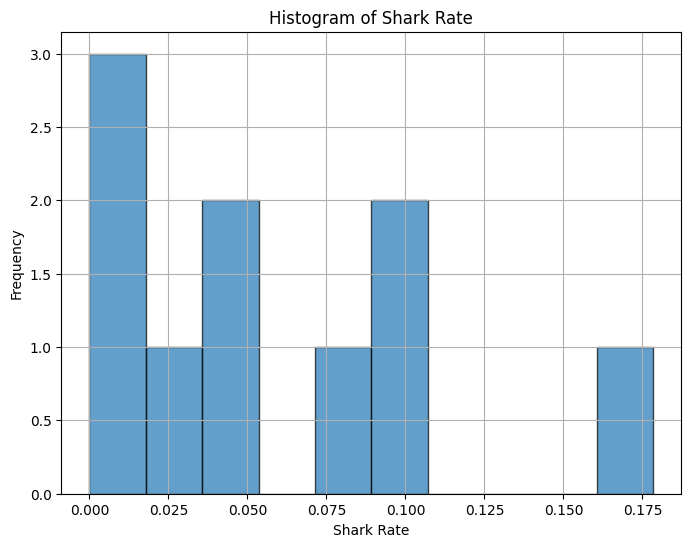

In [41]:
import matplotlib.pyplot as plt

# Example shark_rate data
shark_rate_data = [
    0.0479288369623, 0.098261526833, 0.0821052631579, 0.0388888888889, 0.021463757917,
    0, 0, 0.0952380952381, 0.178391959799, 0
]

# Create histogram of shark_rate
plt.figure(figsize=(8, 6))
plt.hist(shark_rate_data, bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of Shark Rate')
plt.xlabel('Shark Rate')
plt.ylabel('Frequency')
plt.grid(True)

# Display the plot
plt.show()


In [12]:
# profits_df['profits_total'].sum()
profits_df_old['profits_total'].count()

3205467468437.944

In [14]:
profits_df['profits_total'].sum()

3205467468437.944

In [16]:
profits_df.head()

,coin_id,wallet_address,date,net_transfers,balance,price,first_transfer_date,adjusted_net_transfers,profitability_change,profitability_cumulative
0,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-06-29,52.6727892183,52.6727892183,0.0824039688436,2024-06-29,52.6727892183,0,0
1,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-07-15,17.8010851795,70.4738743978,0.12681569103,2024-06-29,17.8010851795,2.33928928152,2.33928928152
2,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009726632680fb29d3f7a9734e3010e2,2024-08-31,30.3633665636,100.837240961,0.122419792313,2024-06-29,30.3633665636,-0.309796014047,2.02949326748
3,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-07-15,-3.63797880709e-12,-3.63797880709e-12,0.12681569103,2024-07-15,-3.63797880709e-12,0,0
4,04a39c15-c70c-40ef-87a6-ff2850e7a5c9,0x00000000009e50a7ddb7a7b0e2ee6604fd120e49,2024-07-25,0.132674074648,0.132674074644,0.190726300024,2024-07-15,0.132674074648,-2.3250544107e-13,-2.3250544107e-13


count   17177272.00
mean         208.11
std        80014.31
min     -9946827.35
25%          -52.35
50%            0.73
75%          176.77
max      9943893.50
Name: profitability, dtype: float64


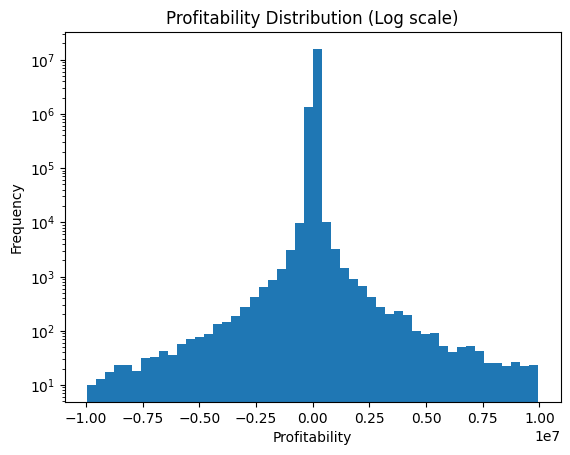

In [9]:

# Check the distribution of profitability values again
# print(profits_df['profitability'].describe())
print(profits_cleaned_df['profitability'].describe())

import matplotlib.pyplot as plt

# Plot distribution of profitability values
profits_cleaned_df['profitability'].plot(kind='hist', bins=50, logy=True)
plt.title('Profitability Distribution (Log scale)')
plt.xlabel('Profitability')
plt.show()

